In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate
from sklearn.model_selection import train_test_split

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 1997
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

Running on GPU


2024-05-26 16:53:21.484853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 16:53:24.902281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 16:53:24.907091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 16:53:24.909472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize_new(field, num_years = 31, first_leap_year_idx = 0):
    
    leap_yr_offsets_jan_feb   = np.array([0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8])
    leap_yr_offsets_after_feb = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8])

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        same_cal_days_idx=[d+365*year+leap_yr_offsets_jan_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    same_cal_days_idx=[365*year+59+int(year/4) for year in range(first_leap_year_idx,num_years,4)]
    # Remove mean
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='constant', 
                                                    overwrite_data=False)
    # Remove linear trend
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='linear', 
                                                    overwrite_data=False)
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        same_cal_days_idx=[d-1+365*year+leap_yr_offsets_after_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize_new(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize_new(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Optimal Input

In [8]:
def quickSetup(X, y,
               test_split_frac,
               val_split_frac,
               lagSteps,
               desired_labels,
               compute_loss,
               OI_eta,
               OI_epochs,
               OI_print_freq,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd

    # Split the data into train and validation sets
    if lagSteps > 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[:-lagSteps], oneHotCost_train[lagSteps:], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    elif lagSteps == 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train, oneHotCost_train, 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    else:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[-lagSteps:], oneHotCost_train[:lagSteps], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)

    K = TrainFullyConnectedNN(x_t, oneHotCost_t, validation_data = (x_v, oneHotCost_v), **NNkwargs)
                   
    best_model = K.quickTrain(decay_func)
    
    oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq)
    
    return oi

def compute_loss(desired_labels, pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(desired_labels, pred)

def OI(model, desired_labels_numpy, compute_loss, eta, max_iters, print_freq):
    
    inp_numpy = np.zeros((1, X.shape[1]), dtype = float)

    if len(desired_labels_numpy.shape) == 1:
        desired_labels_numpy = desired_labels_numpy[np.newaxis, :]
        
    desired_labels = tf.convert_to_tensor(desired_labels_numpy)
    print(f"Desired label : {desired_labels_numpy}")
    print(f"Iter 0, Prediction {tf_to_numpy(model.predict(inp_numpy))}")
    
    for i in range(max_iters):
        inp = tf.convert_to_tensor(inp_numpy)
        grads = GradientDescent_useGradientTape(model, inp, desired_labels, compute_loss)
        grads_numpy = np.squeeze(tf_to_numpy(grads))
        inp_numpy[0,:] = inp_numpy[0,:] - eta*grads_numpy
        if (i+1)%print_freq == 0:
            print(f"Iter {i+1}, Prediction {tf_to_numpy(model.predict(inp_numpy))}")

    optimal_input = np.zeros((13,90,90), dtype = float)
    optimal_input[wetpoints[0], wetpoints[1], wetpoints[2]] = inp_numpy[0]
    
    return optimal_input

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01, 'bias_constraint': None}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

OI_dict = {}
OI_eta = 0.9999
OI_epochs = 8000
OI_print_freq = 200

In [10]:
weight_for_pos = len(oneHotCost[:-2161,0]) / np.sum(oneHotCost[:-2161,0])
weight_for_neg = len(oneHotCost[:-2161,1]) / np.sum(oneHotCost[:-2161,1])
class_weight = {0: weight_for_pos, 1: weight_for_neg}
class_weight

{0: 2.18692936088419, 1: 1.84251012145749}

In [11]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses,
                'metrics': [metricF1, # Custom f1 since metrics.F1Score(name='f1') is not available before tf v2.13
                            'accuracy',
                            'categorical_crossentropy',
                            # metrics.CategoricalCrossentropy(name='cross_entropy'),  # (model's loss-L2 reg loss)
                            # metrics.MeanSquaredError(name='brier_score'),
                            # metrics.TruePositives(name='tp'),
                            # metrics.FalsePositives(name='fp'),
                            # metrics.TrueNegatives(name='tn'),
                            # metrics.FalseNegatives(name='fn'), 
                            # metrics.BinaryAccuracy(name='accuracy'),
                            # metrics.Precision(name='precision'),
                            # metrics.Recall(name='recall'),
                            # metrics.AUC(name='auc'),
                            # metrics.AUC(name='prc', curve='PR'), # precision-recall curve],
                           ],
                'batch_size': 128, 'epochs': 500, #'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_OI_pos', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42, 'class_weight': class_weight,
                'custom_objects': {'metricF1': metricF1}, 'verbose': 2}
    
    OI_dict[f'lag{lagStepsList[i]}'] = quickSetup(X, y, 2161.0/11263.0,
                                             0.2,
                                             lagStepsList[i],
                                             np.array([[1.0,0.0]]),
                                             compute_loss,
                                             OI_eta,
                                             OI_epochs,
                                             OI_print_freq,
                                             step_decay,
                                             layers = Layers, **NNkwargs)

Lag: -60 days, for Theta
Train on 7233 samples, validate on 1809 samples


2024-05-26 16:55:53.004406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 16:55:53.006528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 16:55:53.008630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-05-26 16:55:53.029512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/500


2024-05-26 16:55:55.764057: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 1.19463, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_OI_pos.h5
7233/7233 - 3s - loss: 9.7218 - metricF1: 0.7068 - accuracy: 0.7069 - categorical_crossentropy: 0.9280 - val_loss: 1.1946 - val_metricF1: 0.6887 - val_accuracy: 0.6949 - val_categorical_crossentropy: 0.5682 - lr: 0.0100 - 3s/epoch - 434us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 1.19463
7233/7233 - 0s - loss: 1.6769 - metricF1: 0.7237 - accuracy: 0.7234 - categorical_crossentropy: 0.5736 - val_loss: 1.3516 - val_metricF1: 0.5212 - val_accuracy: 0.5351 - val_categorical_crossentropy: 0.7429 - lr: 0.0100 - 479ms/epoch - 66us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.19463 to 0.99431, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_OI_pos.h5
7233/7233 - 1s - loss: 1.7547 - metricF1: 0.7213 - accuracy: 0.7217 - categorical_crossentropy: 0.5870 - val_loss: 0.9943 - val_metricF1: 0.7468 - val_accuracy: 0.7385 - va

2024-05-26 18:18:00.744858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 18:18:00.747508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 18:18:00.749634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 0.82604, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-30_OI_pos.h5
7257/7257 - 1s - loss: 10.0885 - metricF1: 0.7020 - accuracy: 0.7017 - categorical_crossentropy: 0.9498 - val_loss: 0.8260 - val_metricF1: 0.7816 - val_accuracy: 0.7791 - val_categorical_crossentropy: 0.5296 - lr: 0.0100 - 977ms/epoch - 135us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 0.82604
7257/7257 - 1s - loss: 1.7438 - metricF1: 0.7476 - accuracy: 0.7473 - categorical_crossentropy: 0.5549 - val_loss: 0.8733 - val_metricF1: 0.8351 - val_accuracy: 0.8331 - val_categorical_crossentropy: 0.4831 - lr: 0.0100 - 537ms/epoch - 74us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.82604
7257/7257 - 1s - loss: 1.6026 - metricF1: 0.7540 - accuracy: 0.7540 - categorical_crossentropy: 0.5349 - val_loss: 1.1836 - val_metricF1: 0.7238 - val_accuracy: 0.7179 - val_categorical_crossentropy: 0.5215 - lr: 0.0100 - 521ms/epoch - 72us/

2024-05-26 19:48:46.275108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 19:48:46.277280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 19:48:46.279400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 0.98505, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_OI_pos.h5
7281/7281 - 1s - loss: 9.6364 - metricF1: 0.7134 - accuracy: 0.7134 - categorical_crossentropy: 0.7912 - val_loss: 0.9850 - val_metricF1: 0.7257 - val_accuracy: 0.7276 - val_categorical_crossentropy: 0.5093 - lr: 0.0100 - 1s/epoch - 149us/sample
Epoch 2/500

Epoch 2: val_loss improved from 0.98505 to 0.98396, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_OI_pos.h5
7281/7281 - 1s - loss: 1.7776 - metricF1: 0.7412 - accuracy: 0.7410 - categorical_crossentropy: 0.5569 - val_loss: 0.9840 - val_metricF1: 0.7729 - val_accuracy: 0.7699 - val_categorical_crossentropy: 0.4575 - lr: 0.0100 - 636ms/epoch - 87us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.98396
7281/7281 - 1s - loss: 1.6263 - metricF1: 0.7711 - accuracy: 0.7709 - categorical_crossentropy: 0.5299 - val_loss: 1.1028 - val_metricF1: 0.7431 - val_accuracy: 0.7

2024-05-26 21:19:51.407679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 21:19:51.409826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 21:19:51.411930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 1.09929, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI_pos.h5
7257/7257 - 1s - loss: 11.5808 - metricF1: 0.6787 - accuracy: 0.6785 - categorical_crossentropy: 1.2961 - val_loss: 1.0993 - val_metricF1: 0.7308 - val_accuracy: 0.7328 - val_categorical_crossentropy: 0.5585 - lr: 0.0100 - 1s/epoch - 188us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.09929 to 1.08417, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_OI_pos.h5
7257/7257 - 1s - loss: 1.7083 - metricF1: 0.7510 - accuracy: 0.7507 - categorical_crossentropy: 0.5409 - val_loss: 1.0842 - val_metricF1: 0.7624 - val_accuracy: 0.7537 - val_categorical_crossentropy: 0.5060 - lr: 0.0100 - 558ms/epoch - 77us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 1.08417
7257/7257 - 0s - loss: 1.7880 - metricF1: 0.7642 - accuracy: 0.7642 - categorical_crossentropy: 0.5115 - val_loss: 1.2630 - val_metricF1: 0.6990 - val_accuracy: 

2024-05-26 22:50:01.911300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-26 22:50:01.913558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-26 22:50:01.915772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 1.24443, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI_pos.h5
7233/7233 - 1s - loss: 9.9348 - metricF1: 0.7065 - accuracy: 0.7073 - categorical_crossentropy: 0.8581 - val_loss: 1.2444 - val_metricF1: 0.6782 - val_accuracy: 0.6910 - val_categorical_crossentropy: 0.6048 - lr: 0.0100 - 910ms/epoch - 126us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 1.24443
7233/7233 - 0s - loss: 1.6652 - metricF1: 0.7444 - accuracy: 0.7441 - categorical_crossentropy: 0.5374 - val_loss: 1.8113 - val_metricF1: 0.7752 - val_accuracy: 0.7866 - val_categorical_crossentropy: 0.4921 - lr: 0.0100 - 458ms/epoch - 63us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.24443 to 0.97545, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_OI_pos.h5
7233/7233 - 0s - loss: 1.6115 - metricF1: 0.7628 - accuracy: 0.7622 - categorical_crossentropy: 0.5186 - val_loss: 0.9754 - val_metricF1: 0.7760 - val_accuracy

2024-05-27 00:34:58.003075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-27 00:34:58.005252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-27 00:34:58.007517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 1.72602, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_OI_pos.h5
7209/7209 - 1s - loss: 9.6261 - metricF1: 0.7247 - accuracy: 0.7246 - categorical_crossentropy: 0.8238 - val_loss: 1.7260 - val_metricF1: 0.4964 - val_accuracy: 0.4814 - val_categorical_crossentropy: 0.9268 - lr: 0.0100 - 1s/epoch - 158us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.72602 to 1.09679, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_OI_pos.h5
7209/7209 - 1s - loss: 1.6939 - metricF1: 0.7486 - accuracy: 0.7485 - categorical_crossentropy: 0.5421 - val_loss: 1.0968 - val_metricF1: 0.7704 - val_accuracy: 0.7732 - val_categorical_crossentropy: 0.5430 - lr: 0.0100 - 587ms/epoch - 81us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 1.09679
7209/7209 - 1s - loss: 1.5623 - metricF1: 0.7635 - accuracy: 0.7647 - categorical_crossentropy: 0.5160 - val_loss: 1.4102 - val_metricF1: 0.7787 - val_accuracy: 0

2024-05-27 02:14:39.304625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-27 02:14:39.306774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-27 02:14:39.308880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 2.24170, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_OI_pos.h5
7185/7185 - 1s - loss: 9.8807 - metricF1: 0.7379 - accuracy: 0.7375 - categorical_crossentropy: 0.8711 - val_loss: 2.2417 - val_metricF1: 0.4467 - val_accuracy: 0.4636 - val_categorical_crossentropy: 0.9547 - lr: 0.0100 - 1s/epoch - 142us/sample
Epoch 2/500

Epoch 2: val_loss improved from 2.24170 to 1.45486, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_OI_pos.h5
7185/7185 - 1s - loss: 1.6606 - metricF1: 0.7731 - accuracy: 0.7723 - categorical_crossentropy: 0.5202 - val_loss: 1.4549 - val_metricF1: 0.7703 - val_accuracy: 0.7546 - val_categorical_crossentropy: 0.6233 - lr: 0.0100 - 610ms/epoch - 85us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 1.45486
7185/7185 - 1s - loss: 1.5636 - metricF1: 0.7661 - accuracy: 0.7652 - categorical_crossentropy: 0.5184 - val_loss: 2.2473 - val_metricF1: 0.7140 - val_accuracy:

2024-05-27 03:52:04.290211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-27 03:52:04.292352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-27 03:52:04.294453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 1.16124, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_OI_pos.h5
7161/7161 - 1s - loss: 10.6629 - metricF1: 0.7019 - accuracy: 0.7020 - categorical_crossentropy: 1.0170 - val_loss: 1.1612 - val_metricF1: 0.6884 - val_accuracy: 0.6884 - val_categorical_crossentropy: 0.5604 - lr: 0.0100 - 998ms/epoch - 139us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 1.16124
7161/7161 - 1s - loss: 1.9156 - metricF1: 0.7389 - accuracy: 0.7389 - categorical_crossentropy: 0.5765 - val_loss: 1.2931 - val_metricF1: 0.6599 - val_accuracy: 0.6600 - val_categorical_crossentropy: 0.6402 - lr: 0.0100 - 561ms/epoch - 78us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.16124 to 0.97489, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_OI_pos.h5
7161/7161 - 1s - loss: 1.6616 - metricF1: 0.7382 - accuracy: 0.7382 - categorical_crossentropy: 0.5227 - val_loss: 0.9749 - val_metricF1: 0.7499 - val_accur

2024-05-27 05:28:53.070305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-05-27 05:28:53.072448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-27 05:28:53.074559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Epoch 1/500

Epoch 1: val_loss improved from inf to 1.06287, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI_pos.h5
7137/7137 - 1s - loss: 9.3591 - metricF1: 0.7546 - accuracy: 0.7544 - categorical_crossentropy: 0.7131 - val_loss: 1.0629 - val_metricF1: 0.7821 - val_accuracy: 0.7821 - val_categorical_crossentropy: 0.5054 - lr: 0.0100 - 1s/epoch - 197us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.06287 to 0.99824, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_OI_pos.h5
7137/7137 - 1s - loss: 1.6233 - metricF1: 0.7728 - accuracy: 0.7727 - categorical_crossentropy: 0.5109 - val_loss: 0.9982 - val_metricF1: 0.7692 - val_accuracy: 0.7692 - val_categorical_crossentropy: 0.5354 - lr: 0.0100 - 544ms/epoch - 76us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.99824
7137/7137 - 0s - loss: 1.7107 - metricF1: 0.7672 - accuracy: 0.7674 - categorical_crossentropy: 0.5274 - val_loss: 1.3179 - val_metricF1: 0.7631 - val_accuracy:

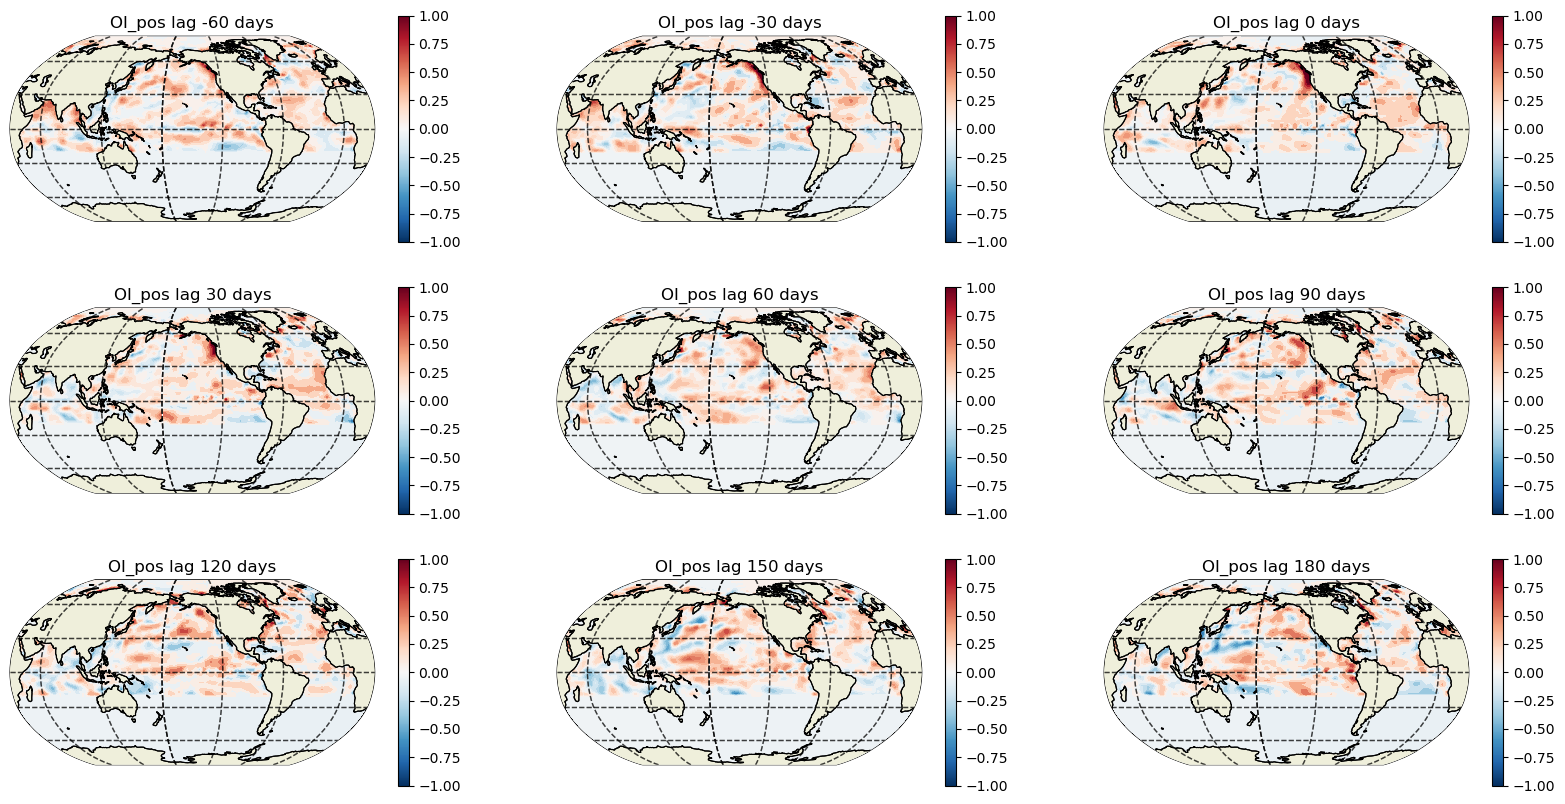

In [12]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      OI_dict[f'lag{lag}'],
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"OI_pos lag {lag} days")
    subplot_idx += 1

# plt.title("Optimal Inputs")
plt.show()

In [14]:
ds_oi = xr.Dataset()

ds_oi = ds_oi.assign(OI_minus60 = xr.DataArray(OI_dict['lag-60']),
                     OI_minus30 = xr.DataArray(OI_dict['lag-30']),
                     OI_0  = xr.DataArray(OI_dict['lag0']),
                     OI_30 = xr.DataArray(OI_dict['lag30']),
                     OI_60 = xr.DataArray(OI_dict['lag60']),
                     OI_90 = xr.DataArray(OI_dict['lag90']),
                     OI_120 = xr.DataArray(OI_dict['lag120']),
                     OI_150 = xr.DataArray(OI_dict['lag150']),
                     OI_180 = xr.DataArray(OI_dict['lag180']))

ds_oi.to_netcdf('LRP_output_forHelen/OI_v4r5_pos_newAnomalies_shuffleVal_reweight.nc')